In [1]:
%matplotlib inline
# %matplotlib notebook

from __future__ import print_function

try:
    from importlib import reload
except:
    pass

import os
import sys
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy.constants import h
from scipy.integrate import simps

from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import astropy.units as u

In [2]:
import pyCoCo as pccsims
import pycoco as pcc

reload(pcc)
reload(pcc.defaults)
reload(pcc.kcorr)
reload(pcc.classes)
reload(pccsims)

<module 'pyCoCo' from '/Users/berto/Code/CoCo/pyCoCo.cpython-36m-darwin.so'>

## Sky Brightness
---
Load in the sky spectrum

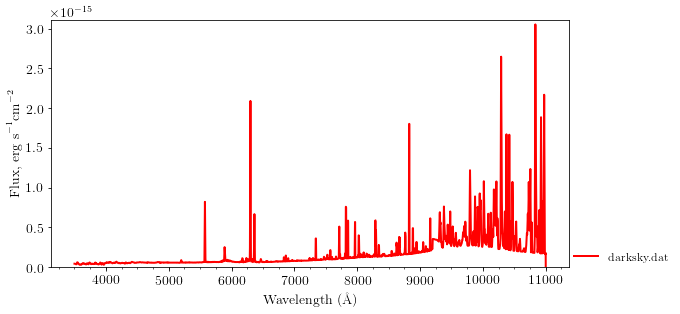

In [3]:
reload(pcc)
reload(pcc.kcorr)
reload(pcc.classes)

dark_sky_path = os.path.join(os.environ["LSST_THROUGHPUTS_BASELINE"],"darksky.dat")
darksky = pcc.SpectrumClass()
darksky.load(dark_sky_path, wavelength_u = u.nm, flux_u = u.cgs.erg / u.si.cm ** 2 / u.si.s / u.nm,
             fmt = "ascii.commented_header", wmin = 3500*u.angstrom, wmax = 11000*u.angstrom,)
darksky.plot()

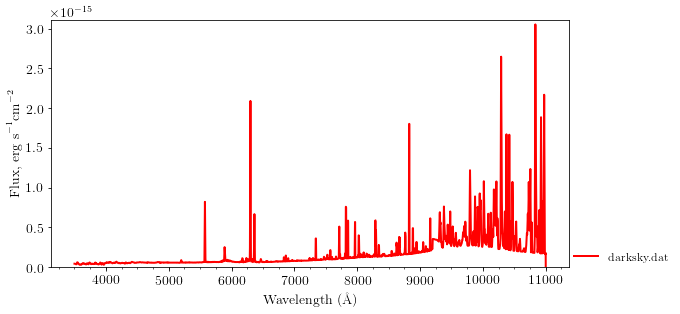

In [5]:
reload(pcc)
reload(pcc.kcorr)
reload(pcc.classes)

dark_sky_path = os.path.join(os.environ["LSST_THROUGHPUTS_BASELINE"],"darksky.dat")
darksky = pcc.SpectrumClass()
darksky.load(dark_sky_path, wavelength_u = u.nm,
             fmt = "ascii.commented_header", wmin = 3500*u.angstrom, wmax = 11000*u.angstrom,)
darksky.plot()

Which is equivalent to:

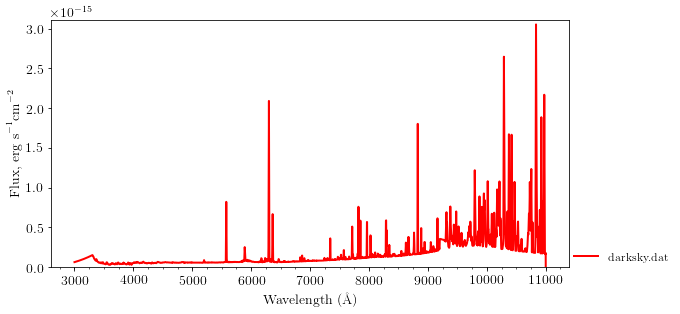

In [4]:
darksky = pcc.kcorr.load_dark_sky_spectrum()
darksky.plot()

From - http://smtn-002.lsst.io/en/latest/#sky-counts
>When calculating sky background counts per pixel, instead of using the entire hardware system plus atmosphere, the Fν(λ)Fν(λ) value for the sky spectrum should be multiplied by only the hardware.[1] The skybrightness in magnitudes per sq arcsecond then is used to calculate counts per sq arcsecond, and converted to counts per pixel using the pixelScale, 0.2”/pixel.

## Hardware Filters (No Atmosphere)

<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence \_
<input>:15: DeprecationWarning: invalid escape sequence 

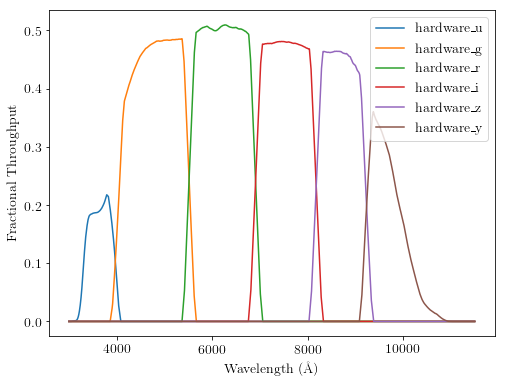

In [5]:
lsst_hardware_filters = ["hardware_u", "hardware_g", "hardware_r", "hardware_i", "hardware_z", "hardware_y"]

fdict = {}

for filter_name in lsst_hardware_filters:
    filter_path = os.path.join(pcc._default_filter_dir_path, filter_name + ".dat")
    fdict[filter_name] = pcc.FilterClass()
    fdict[filter_name].load(filter_path)
    fdict[filter_name].filter_name = filter_name
    
fig = plt.figure(figsize=[8,6])
ax1 = fig.add_subplot(111)

for filter_name in lsst_hardware_filters:
    ax1.plot(fdict[filter_name].data["wavelength"], fdict[filter_name].data["throughput"], label = r"$\textnormal{" + fdict[filter_name].filter_name.replace("_", "\_") + "}$" )

ax1.set_xlabel(r"$\textnormal{Wavelength (\AA)}$")
ax1.set_ylabel(r"$\textnormal{Fractional Throughput}$")

ax1.legend(loc = 0)
plt.show()

## Zeropoints
---
To calculate the sky brightness we need to calculate the zeropoint. In AB this means integrating 3.63078e-20 erg s^-1 cm^-2 Hz^-1 across the bandpass, and dividing by the filter area.

The function that does this is **`pcc.kcorr.calc_AB_zp(...)`** e.g.

In [6]:
pcc.kcorr.calc_AB_zp("V")

21.101139964344181

## LSST Values
---
given in view-source:http://smtn-002.lsst.io/en/latest/#sky-counts :

<table border="1" class="docutils">
<colgroup>
<col width="16%" />
<col width="84%" />
</colgroup>
<tbody valign="top">
<tr class="row-odd"><td>Filter</td>
<td>Sky brightness (mag/arcsecond^2)</td>
</tr>
<tr class="row-even"><td>u</td>
<td>22.95</td>
</tr>
<tr class="row-odd"><td>g</td>
<td>22.24</td>
</tr>
<tr class="row-even"><td>r</td>
<td>21.20</td>
</tr>
<tr class="row-odd"><td>i</td>
<td>20.47</td>
</tr>
<tr class="row-even"><td>z</td>
<td>19.60</td>
</tr>
<tr class="row-odd"><td>y</td>
<td>18.63</td>
</tr>
</tbody>
</table>

I get:

In [7]:
quoted_vals = {"hardware_u" : 22.95,
               "hardware_g" : 22.24,
               "hardware_r" : 21.20,
               "hardware_i" : 20.47,
               "hardware_z" : 19.60,
               "hardware_y" : 18.63}

print("FILTER | m_sky, Mag Arcsec^-2 | Quoted Sky Brightness, Mag Arcsec^-2 |  dmag (calc-quote)")
for filter_name in lsst_hardware_filters:
    zp = pcc.kcorr.calc_AB_zp(filter_name)
    m_sky = -2.5 * np.log10(pcc.kcorr.calc_spectrum_filter_flux(filter_name, darksky)) - zp
    
    print(filter_name, "|", m_sky, "|", quoted_vals[filter_name], "|", m_sky-quoted_vals[filter_name]) 


FILTER | m_sky, Mag Arcsec^-2 | Quoted Sky Brightness, Mag Arcsec^-2 |  dmag (calc-quote)
hardware_u | 22.943966399 | 22.95 | -0.00603360099102
hardware_g | 22.2648186165 | 22.24 | 0.02481861648
hardware_r | 21.2076057322 | 21.2 | 0.00760573218803
hardware_i | 20.4920355953 | 20.47 | 0.0220355952619
hardware_z | 19.607146037 | 19.6 | 0.00714603695137
hardware_y | 18.6405746851 | 18.63 | 0.0105746850792


Good agreement.

Converted the above into a function **`calc_m_darksky`**

In [8]:
pcc.kcorr.calc_m_darksky("LSST_g")

22.250751087669009

In [9]:
pcc.kcorr.calc_m_darksky("BessellV")

21.717677839340244